# Tutorial for MIRI Post-Pipeline Contrast Analyses Using spaceKLIP

---

In this notebook, you will explore the analysis of MIRI coronagraphy data from the JWST ERS program on Direct Observations of Exoplanetary Systems [Program 1386](https://www.stsci.edu/jwst/science-execution/program-information?id=1386), with a focus on the exoplanet HIP 65426 b. This tutorial provides a detailed, step-by-step guide to performing contrast analysis using the spaceKLIP pipeline. By the end of this notebook, you will gain practical experience with tools and techniques essential for analyzing MIRI coronagraphic data. This knowledge will equip you to apply these methods to similar datasets, enhancing your ability to extract meaningful results from high-contrast imaging observations.

<div class="alert alert-warning">
    
<b>Prerequisite:</b> This notebook assumes you have already run the ["Tutorial for MIRI Coronagraphy Reduction with spaceKLIP"](https://spaceklip.readthedocs.io/en/latest/tutorials/tutorial_MIRI_reductions.html) notebook. The output files from that reduction must be present to be analyzed in this notebook.

</div>

<h1 style="font-size: 24px;">Table of Contents</h1>

* [1. Introduction](#Introduction)
* [2. Setup and Imports](#Setup-and-Imports)
* [3. Prepare for Contrast Calculations](#Prepare-for-Contrast-Calculations)
    * [3.1 Re-read Stage 3 Outputs into Database](#Re-read-Stage-3-Outputs-into-Database)
    * [3.2 Preparation: Stellar Photometry Model](#Preparation:-Stellar-Photometry-Model)
    * [3.3 Prior Knowledge About the Companion](#Prior-Knowledge-About-the-Companion)
    * [3.4 Set up Analysis Tools](#Set-up-Analysis-Tools)
* [4. Compute Raw Contrasts](#Compute-Raw-Contrasts)
* [5. Compute Calibrated Contrasts](#Compute-Calibrated-Contrasts)
* [6. Extract measurements of the planet](#Extract-measurements-of-the-planet)


---

## Introduction

A detailed introduction to contrast curves is available in the ["Tutorial for NIRCam Coronagraphy Reduction with spaceKLIP"](https://spaceklip.readthedocs.io/en/latest/tutorials/tutorial_NIRCam_reductions.html) notebook. Here, we jump directly into analyzing the MIRI data, delving into the nuances of these contrast curves and using them to interpret the extracted properties of the companion HIP 65426 b.



---

## Setup and Imports

In [1]:
import os
import glob

import numpy as np
import astropy
import astropy.table

import matplotlib.pyplot as plt

import spaceKLIP

Note that currently the import of `webbpsf_ext` has a side effect of configuring extra verbose logging. We're not interested in that logging text, so let's quiet it.

In [2]:
import webbpsf_ext
webbpsf_ext.setup_logging('WARN', verbose=False)

In [3]:
# Name the root directory where we will keep the data for this tutorial.
data_root = 'data_miri_hd65426'

---

## Prepare for Contrast Calculations

### Re-read Stage 3 Outputs into Database 

Read in the output files produced in the MIRI coronagraph data reduction notebook into a database.

For this example, we will restrict our analysis to just one filter. This approach is sufficient for demonstration purposes and is faster than running the analysis for all filters.

In [4]:
filt = 'F1550C'  # Set to None to disable filter selection and load all filters.

In [5]:
# Define the directory containing the KLIP output files.
input_dir = os.path.join(data_root, 'klipsub')

# Get a sorted list of FITS files that match the filter and KLmodes pattern.
fitsfiles = sorted(glob.glob(os.path.join(input_dir, f"*{filt}*KLmodes-all.fits")))

# Initialize the SpaceKLIP database with the root data directory.
database = spaceKLIP.database.Database(output_dir=data_root)

# Read the JWST data from the FITS files into the database.
database.read_jwst_s3_data(fitsfiles)

[spaceKLIP.database:INFO] --> Identified 1 concatenation(s)
[spaceKLIP.database:INFO]   --> Concatenation 1: JWST_MIRI_MIRIMAGE_F1550C_NONE_4QPM_1550_MASK1550
 TYPE  EXP_TYPE DATAMODL TELESCOP ... SUBSECTS    KLMODES     BUNIT  BLURFWHM
------ -------- -------- -------- ... -------- -------------- ------ --------
PYKLIP MIR_4QPM   STAGE3     JWST ...        1 1,2,5,10,20,50 MJy/sr      nan
PYKLIP MIR_4QPM   STAGE3     JWST ...        1 1,2,5,10,20,50 MJy/sr      nan
PYKLIP MIR_4QPM   STAGE3     JWST ...        1 1,2,5,10,20,50 MJy/sr      nan


---

### Preparation: Stellar Photometry Model

To accurately assess the contrast performance of our imaging system, we need a model of the target star. This model helps us compute the star’s flux in the observational filters and serves as a reference for evaluating our contrast measurements. The stellar photometry model can be provided in one of two formats: a Vizier VOTable, or a simple text file with columns giving wavelenth in microns and flux in Jy.

We provide examples of both types of files, courtesy of Aarynn Carter. Only one is needed; we offer both purely as examples. These are the same files explored in greater detail in the ["Tutorial for NIRCam Post-Pipeline Contrast Analyses Using spaceKLIP"](https://spaceklip.readthedocs.io/en/latest/tutorials/tutorial_NIRCam_contrast_analyses.html) notebook. 


In [6]:
star_photometry_vot = 'HIP65426.vot'  # VOTable.
star_photometry_txt = 'HIP65426A_sdf_phoenix_m+modbb_disk_r.txt'  # Text file.
star_spectral_type = 'A2V'  # Spectral type.

---

### Prior Knowledge About the Companion 

In this example, we focus on a known companion whose position and expected characteristics are already known. To ensure our contrast calculations accurately reflect the imaging system's performance, we need to mask out this known companion. This step is crucial because it prevents the known companion from affecting our contrast measurements, thereby providing a clearer picture of the system's capability to detect new, faint companions.

To locate the known companion, HIP 65426 b, we can use the coordinates provided by [whereistheplanet.com](http://whereistheplanet.com/) for the observation date of August 15, 2022. According to the data:

```
RA Offset = 416.618 +/- 0.045 mas
Dec Offset = -703.443 +/- 0.051 mas
Separation = 817.558 +/- 0.036 mas
PA = 149.364 +/- 0.004 deg
Reference: Blunt et al. 2023
```

The coordinates given specify the companion's position relative to the host star, with measurements in milli-arcseconds (mas) for the right ascension (RA) and declination (Dec), as well as the separation and position angle (PA) from the star.

Measuring the companion starts from an estimated contrast, which can be approximate and based on prior knowledge. 

In [7]:
comp_dra = 0.416  # arcsec
comp_ddec = -0.703  # arcsec
comp_est_contrast = 1e-4 # contrast ratio estimate

---

### Set up Analysis Tools

In this step, we set up the necessary tools for analyzing the data. This involves initializing the `AnalysisTools` class and providing it with the database of files that will be used in the analysis. The `AnalysisTools` class in spaceKLIP provides a suite of analysis tools, allowing you to compute raw and calibrated contrast curves, inject and recover synthetic companions, and extract companion parameters directly from high-contrast imaging data.

In [8]:
# Initialize the spaceKLIP contrast estimation class.
analysistools = spaceKLIP.analysistools.AnalysisTools(database)

---

## Compute Raw Contrasts

<div class="alert alert-danger">
    
<b>Warning:</b> Currently, a bug affecting the calculation of the raw and calibrated contrast curves is under investigation. While these steps will execute when run, please keep in mind that the resulting plot may not be meaningful.

</div>

For detailed instructions on computing the raw contrasts, please refer to the "Compute Raw Contrasts" section in the ["Tutorial for NIRCam Post-Pipeline Contrast Analyses Using spaceKLIP"](https://spaceklip.readthedocs.io/en/latest/tutorials/tutorial_NIRCam_contrast_analyses.html) notebook. 

The calculation of raw contrast curves iterates over all filters and datasets present in the database. If you have applied multiple reduction strategies—such as Angular Differential Imaging (ADI), Reference Differential Imaging (RDI), or combinations like ADI+RDI, or varied the number of KL modes or annuli for optimization—the raw contrast calculation will be performed separately for each strategy or configuration.

[spaceKLIP.analysistools:INFO] Copying starfile HIP65426A_sdf_phoenix_m+modbb_disk_r.txt to data_miri_hd65426/rawcon/HIP65426A_sdf_phoenix_m+modbb_disk_r.txt
[spaceKLIP.analysistools:INFO] --> Concatenation JWST_MIRI_MIRIMAGE_F1550C_NONE_4QPM_1550_MASK1550
[spaceKLIP.analysistools:INFO] Analyzing file data_miri_hd65426/klipsub/ADI+RDI_NANNU1_NSUBS1_JWST_MIRI_MIRIMAGE_F1550C_NONE_4QPM_1550_MASK1550-KLmodes-all.fits
[spaceKLIP.psf:INFO]   --> Generating WebbPSF model
[spaceKLIP.analysistools:INFO]   Masking out areas for MIRI 4QPM coronagraph
[spaceKLIP.analysistools:INFO]   Masking out 1 known companions using provided parameters.
[spaceKLIP.analysistools:INFO]   Measuring raw contrast in annuli
[spaceKLIP.analysistools:INFO]   Measuring raw contrast for masked data
[spaceKLIP.analysistools:INFO]  Plot saved in data_miri_hd65426/rawcon/ADI+RDI_NANNU1_NSUBS1_JWST_MIRI_MIRIMAGE_F1550C_NONE_4QPM_1550_MASK1550-KLmodes-all_masked.pdf


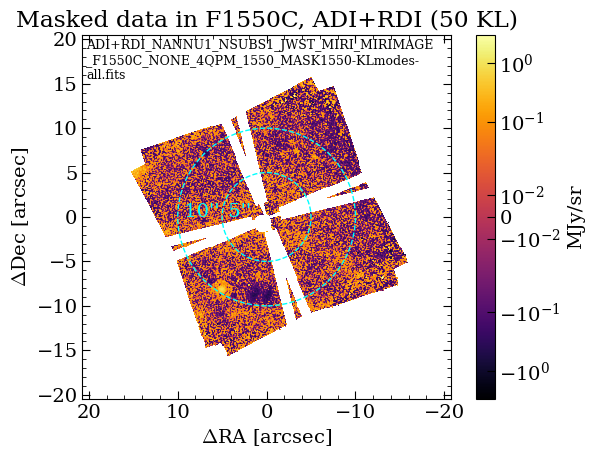

[spaceKLIP.analysistools:INFO]  Plot saved in data_miri_hd65426/rawcon/ADI+RDI_NANNU1_NSUBS1_JWST_MIRI_MIRIMAGE_F1550C_NONE_4QPM_1550_MASK1550-KLmodes-all_rawcon.pdf


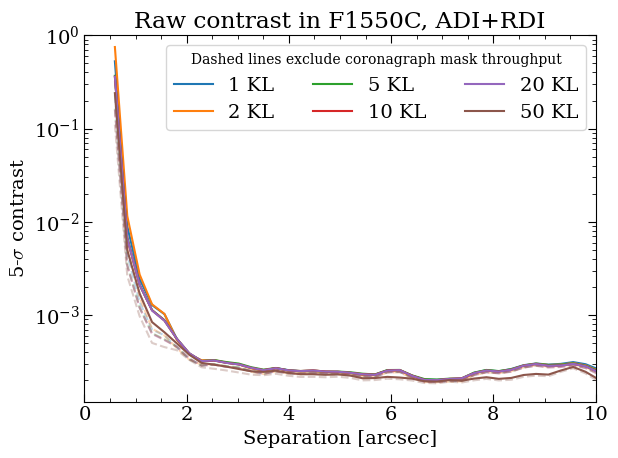

Contrast results and plots saved to data_miri_hd65426/rawcon/ADI+RDI_NANNU1_NSUBS1_JWST_MIRI_MIRIMAGE_F1550C_NONE_4QPM_1550_MASK1550-KLmodes-all_seps.npy, data_miri_hd65426/rawcon/ADI+RDI_NANNU1_NSUBS1_JWST_MIRI_MIRIMAGE_F1550C_NONE_4QPM_1550_MASK1550-KLmodes-all_cons.npy
[spaceKLIP.analysistools:INFO] Analyzing file data_miri_hd65426/klipsub/ADI_NANNU1_NSUBS1_JWST_MIRI_MIRIMAGE_F1550C_NONE_4QPM_1550_MASK1550-KLmodes-all.fits
[spaceKLIP.psf:INFO]   --> Generating WebbPSF model
[spaceKLIP.analysistools:INFO]   Masking out areas for MIRI 4QPM coronagraph
[spaceKLIP.analysistools:INFO]   Masking out 1 known companions using provided parameters.
[spaceKLIP.analysistools:INFO]   Measuring raw contrast in annuli
[spaceKLIP.analysistools:INFO]   Measuring raw contrast for masked data
[spaceKLIP.analysistools:INFO]  Plot saved in data_miri_hd65426/rawcon/ADI_NANNU1_NSUBS1_JWST_MIRI_MIRIMAGE_F1550C_NONE_4QPM_1550_MASK1550-KLmodes-all_masked.pdf


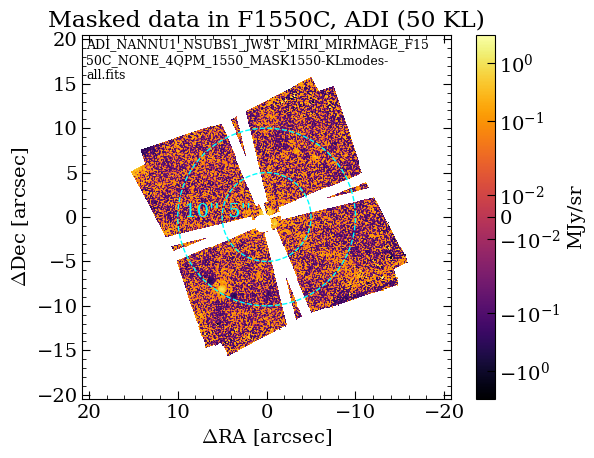

[spaceKLIP.analysistools:INFO]  Plot saved in data_miri_hd65426/rawcon/ADI_NANNU1_NSUBS1_JWST_MIRI_MIRIMAGE_F1550C_NONE_4QPM_1550_MASK1550-KLmodes-all_rawcon.pdf


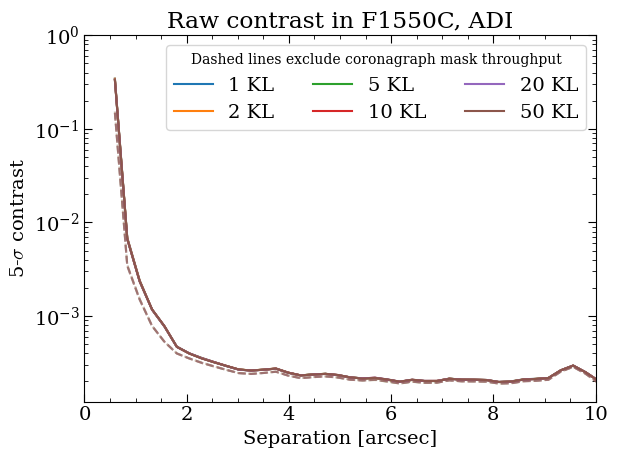

Contrast results and plots saved to data_miri_hd65426/rawcon/ADI_NANNU1_NSUBS1_JWST_MIRI_MIRIMAGE_F1550C_NONE_4QPM_1550_MASK1550-KLmodes-all_seps.npy, data_miri_hd65426/rawcon/ADI_NANNU1_NSUBS1_JWST_MIRI_MIRIMAGE_F1550C_NONE_4QPM_1550_MASK1550-KLmodes-all_cons.npy
[spaceKLIP.analysistools:INFO] Analyzing file data_miri_hd65426/klipsub/RDI_NANNU1_NSUBS1_JWST_MIRI_MIRIMAGE_F1550C_NONE_4QPM_1550_MASK1550-KLmodes-all.fits
[spaceKLIP.psf:INFO]   --> Generating WebbPSF model
[spaceKLIP.analysistools:INFO]   Masking out areas for MIRI 4QPM coronagraph
[spaceKLIP.analysistools:INFO]   Masking out 1 known companions using provided parameters.
[spaceKLIP.analysistools:INFO]   Measuring raw contrast in annuli
[spaceKLIP.analysistools:INFO]   Measuring raw contrast for masked data
[spaceKLIP.analysistools:INFO]  Plot saved in data_miri_hd65426/rawcon/RDI_NANNU1_NSUBS1_JWST_MIRI_MIRIMAGE_F1550C_NONE_4QPM_1550_MASK1550-KLmodes-all_masked.pdf


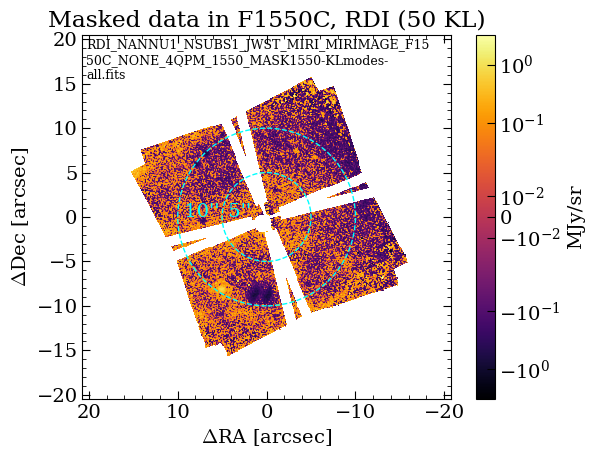

[spaceKLIP.analysistools:INFO]  Plot saved in data_miri_hd65426/rawcon/RDI_NANNU1_NSUBS1_JWST_MIRI_MIRIMAGE_F1550C_NONE_4QPM_1550_MASK1550-KLmodes-all_rawcon.pdf


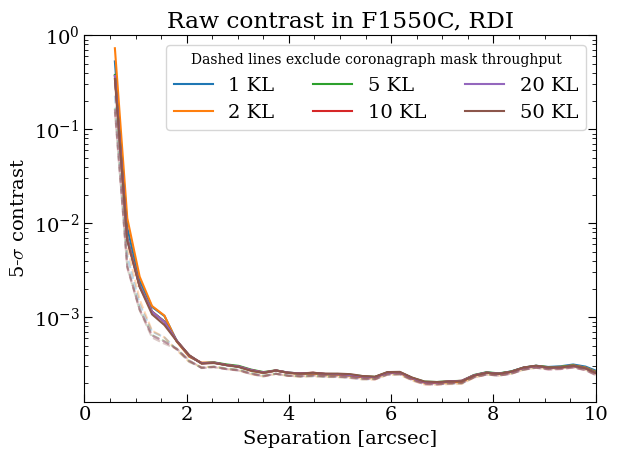

Contrast results and plots saved to data_miri_hd65426/rawcon/RDI_NANNU1_NSUBS1_JWST_MIRI_MIRIMAGE_F1550C_NONE_4QPM_1550_MASK1550-KLmodes-all_seps.npy, data_miri_hd65426/rawcon/RDI_NANNU1_NSUBS1_JWST_MIRI_MIRIMAGE_F1550C_NONE_4QPM_1550_MASK1550-KLmodes-all_cons.npy


In [9]:
# Compute raw contrast.
analysistools.raw_contrast(
    star_photometry_txt,  # Stellar photometry.
    spectral_type=star_spectral_type,  # Spectral type.
    # [RA offset (arcsec), Dec offset (arcsec), mask radius (lambda/D)].
    companions=[[comp_dra, comp_ddec, 2.]],
    subdir='rawcon')

The results of the raw contrast curve calculations are stored in the `rawcon` subdirectory within the main data directory. This directory contains several types of output files:

* **Masked Data & Contrast Curves**: These files include visual representations of the reduced images and plots of the contrast curves. The raw contrast curves are also saved in `.npy` format, which are NumPy data dump files. **Make a note about the mask**

The results should be automatically plotted when executing `raw_contrast`. To demonstrate how to access and visualize these results, we'll provide an example of how to read and plot one of these contrast curves. The results should be automatically plotted when executing `raw_contrast`.


Additionally, we plan to migrate to saving as astropy ECSV format text files, for easy use with `astropy.table`. 

In [10]:
# Optional: open the saved PDF files.
!open data_miri_hd65426/rawcon/*pdf

In [11]:
!ls data_miri_hd65426/rawcon/*npy

data_miri_hd65426/rawcon/ADI+RDI_NANNU1_NSUBS1_JWST_MIRI_MIRIMAGE_F1550C_NONE_4QPM_1550_MASK1550-KLmodes-all_cons.npy
data_miri_hd65426/rawcon/ADI+RDI_NANNU1_NSUBS1_JWST_MIRI_MIRIMAGE_F1550C_NONE_4QPM_1550_MASK1550-KLmodes-all_cons_mask.npy
data_miri_hd65426/rawcon/ADI+RDI_NANNU1_NSUBS1_JWST_MIRI_MIRIMAGE_F1550C_NONE_4QPM_1550_MASK1550-KLmodes-all_seps.npy
data_miri_hd65426/rawcon/ADI_NANNU1_NSUBS1_JWST_MIRI_MIRIMAGE_F1550C_NONE_4QPM_1550_MASK1550-KLmodes-all_cons.npy
data_miri_hd65426/rawcon/ADI_NANNU1_NSUBS1_JWST_MIRI_MIRIMAGE_F1550C_NONE_4QPM_1550_MASK1550-KLmodes-all_cons_mask.npy
data_miri_hd65426/rawcon/ADI_NANNU1_NSUBS1_JWST_MIRI_MIRIMAGE_F1550C_NONE_4QPM_1550_MASK1550-KLmodes-all_seps.npy
data_miri_hd65426/rawcon/RDI_NANNU1_NSUBS1_JWST_MIRI_MIRIMAGE_F1550C_NONE_4QPM_1550_MASK1550-KLmodes-all_cons.npy
data_miri_hd65426/rawcon/RDI_NANNU1_NSUBS1_JWST_MIRI_MIRIMAGE_F1550C_NONE_4QPM_1550_MASK1550-KLmodes-all_cons_mask.npy
data_miri_hd65426/rawcon/RDI_NANNU1_NSUBS1_JWST_MIRI_MIRIMAGE

The PDFs of the reduced images highlight separations at 5" and 10" to help correlate features in the contrast curves with those in the images. The contrast curve shows a steep drop at small separations due to high residual speckle noise near the star, where diffraction and instrumental artifacts dominate. At larger separations, the curve flattens as it reaches the background- and detector-limited regimes. The "wiggles" in the flat region are caused by the presence of background objects.


---

## Compute Calibrated Contrasts

For detailed instructions on computing the calibrated contrasts, please refer to the "Compute Calibrated Contrasts" section in the ["Tutorial for NIRCam Post-Pipeline Contrast Analyses Using spaceKLIP"](https://spaceklip.readthedocs.io/en/latest/tutorials/tutorial_NIRCam_contrast_analyses.html) notebook. 

Below, we highlight several additional configurable parameters

**Note**: The calibration process can take some time, depending on the number of injected companions and the subtraction strategies applied. During execution, progress bars will provide real-time updates on the status of the computation. To speed up the tutorial, we have specified a smaller number of separations and position angles (PAs) than is typically used. However, it is crucial to have enough separation sampling to understand how KLIP throughput varies with separation and sufficient PA sampling to accurately determine the median flux loss at each separation. The default values for these parameters offer a more typical use case.

[spaceKLIP.analysistools:INFO] --> Concatenation JWST_MIRI_MIRIMAGE_F1550C_NONE_4QPM_1550_MASK1550
[spaceKLIP.psf:INFO]   --> Generating WebbPSF model
[spaceKLIP.analysistools:INFO] Analyzing file data_miri_hd65426/klipsub/ADI+RDI_NANNU1_NSUBS1_JWST_MIRI_MIRIMAGE_F1550C_NONE_4QPM_1550_MASK1550-KLmodes-all.fits
[spaceKLIP.analysistools:INFO] Injecting and recovering synthetic companions. This may take a while...
[spaceKLIP.analysistools:INFO] --> 1/6 source positions not suitable for injection.


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

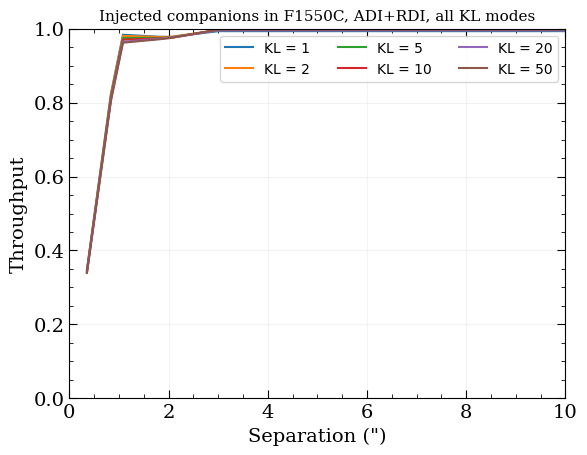

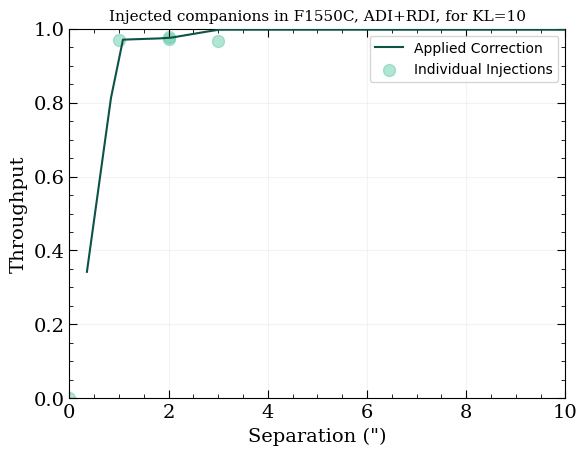

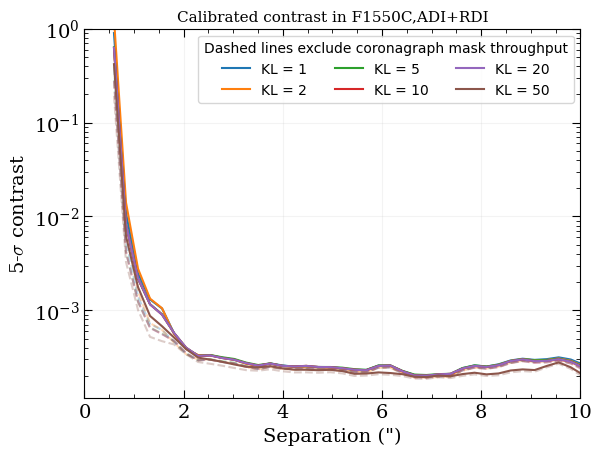

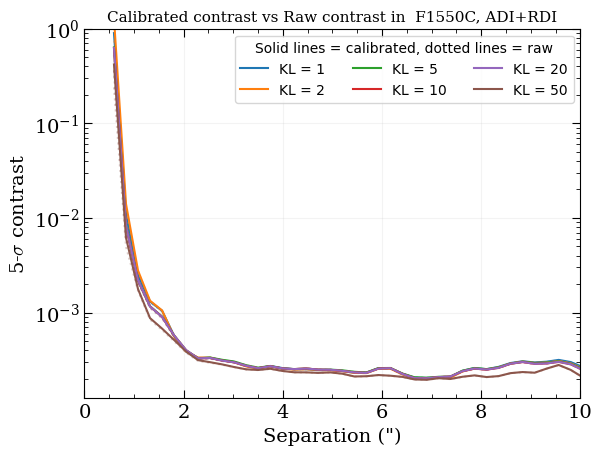

[spaceKLIP.analysistools:INFO] Analyzing file data_miri_hd65426/klipsub/ADI_NANNU1_NSUBS1_JWST_MIRI_MIRIMAGE_F1550C_NONE_4QPM_1550_MASK1550-KLmodes-all.fits
[spaceKLIP.analysistools:INFO] Injecting and recovering synthetic companions. This may take a while...
[spaceKLIP.analysistools:INFO] --> 1/6 source positions not suitable for injection.


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

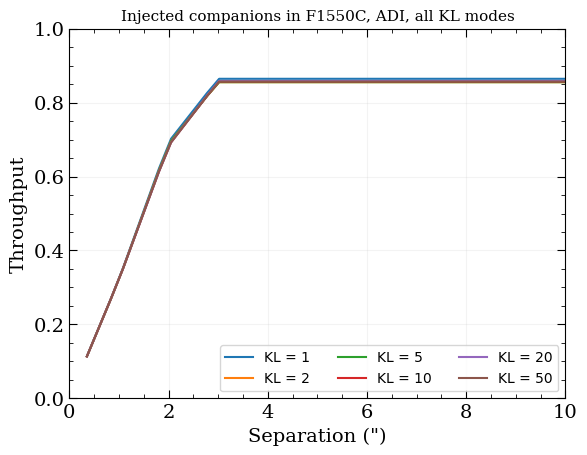

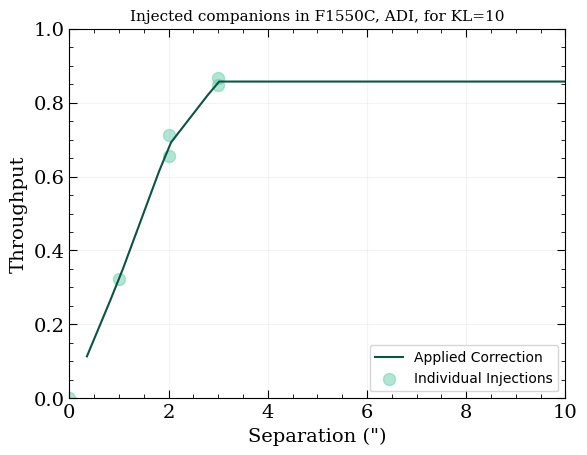

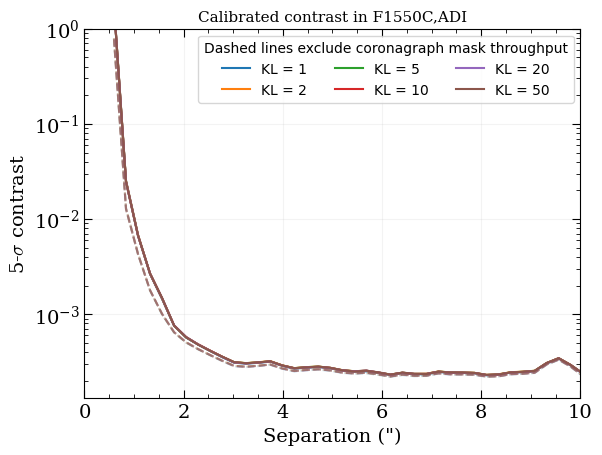

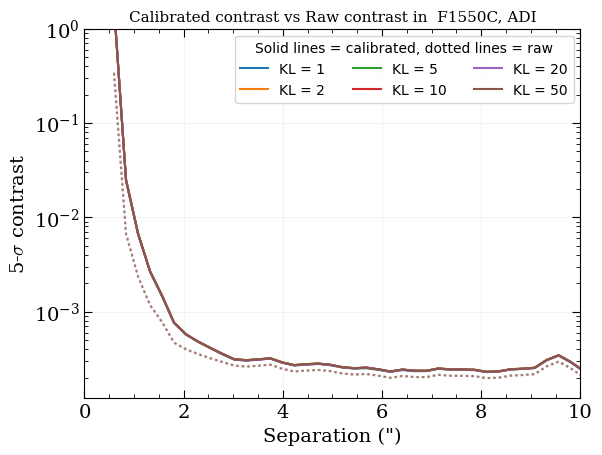

[spaceKLIP.analysistools:INFO] Analyzing file data_miri_hd65426/klipsub/RDI_NANNU1_NSUBS1_JWST_MIRI_MIRIMAGE_F1550C_NONE_4QPM_1550_MASK1550-KLmodes-all.fits
[spaceKLIP.analysistools:INFO] Injecting and recovering synthetic companions. This may take a while...
[spaceKLIP.analysistools:INFO] --> 1/6 source positions not suitable for injection.


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

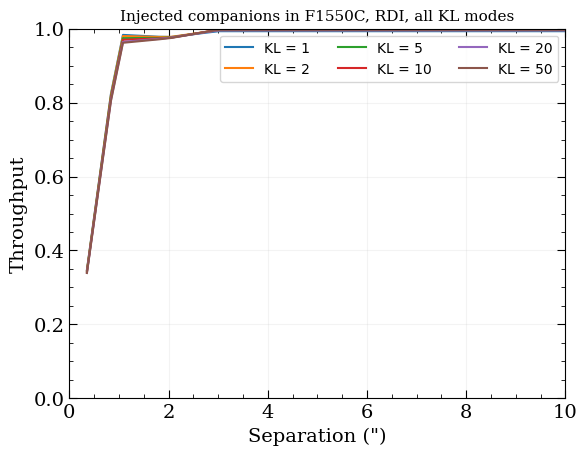

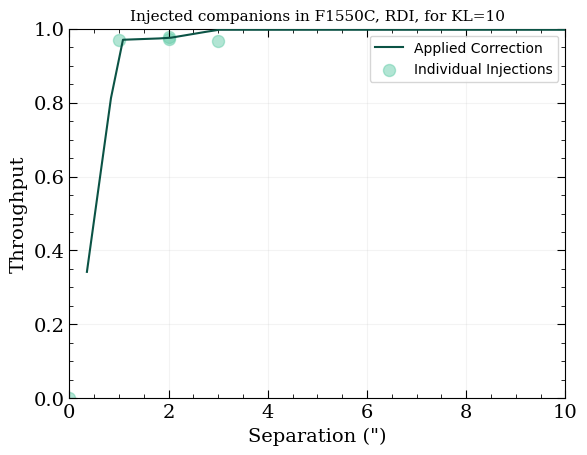

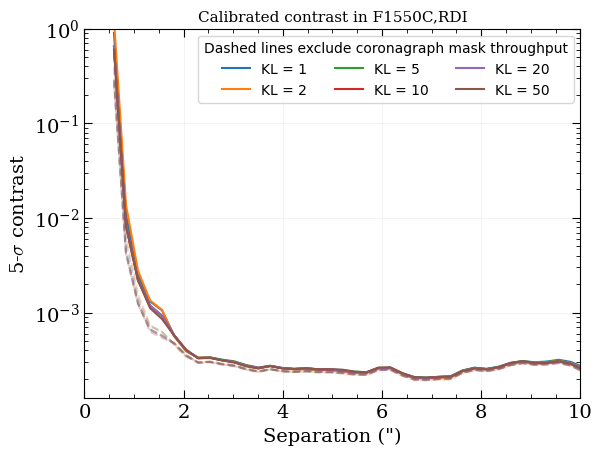

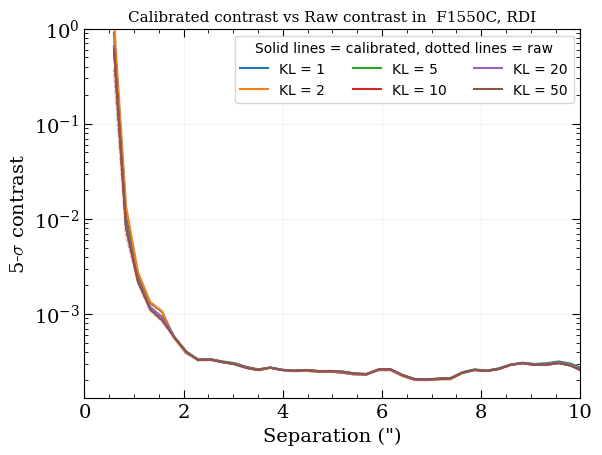

In [12]:
#Compute calibrated contrast.
analysistools.calibrate_contrast(
    rawcon_subdir='rawcon', # Directory raw contrasts are saved to.
    # [RA offset (arcsec), Dec offset (arcsec), mask radius (lambda/D)].
    companions=[[comp_dra, comp_ddec, 2.]],
    injection_seps=[1, 2, 3], # arcsec
    injection_pas=[45, 90],  # degrees
    injection_flux_sigma=20,
    # Spacing between injected companion, None = 1 companion per injection+recovery.
    multi_injection_spacing=None,
    use_saved=False,  # Useful for debugging / changing plots / sharing files.
    subdir='calcon')  # Save directory.

The results of the calibrated contrast curve calculations are stored in the `calcon` subdirectory within the main data directory. This directory contains the following output files:

* **Throughput & Calibrated Contrast Curves**: These files feature visual representations of throughput correction plots and calibrated contrast curves for each PSF subtraction strategy and KL mode. One plot specifically shows the median KL mode (10 in this case) with injected companions overlaid as blue dots, where each dot represents a different separation and PA angle. The calibrated contrast curves and injected companion data are also saved as `.npy` files.

The results are automatically plotted when executing `calibrate_contrast`. For an example of how to read and plot from the .npy files, refer to the demonstration above.

Again, we plan to migrate to saving as astropy ECSV format text files, for easy use with `astropy.table`. 

---

In [13]:
# Optional: open the saved PDF files.
!open data_miri_hd65426/calcon/*pdf

In [14]:
!ls data_miri_hd65426/calcon/*npy

data_miri_hd65426/calcon/ADI+RDI_NANNU1_NSUBS1_JWST_MIRI_MIRIMAGE_F1550C_NONE_4QPM_1550_MASK1550-KLmodes-all_cal_cons.npy
data_miri_hd65426/calcon/ADI+RDI_NANNU1_NSUBS1_JWST_MIRI_MIRIMAGE_F1550C_NONE_4QPM_1550_MASK1550-KLmodes-all_cal_maskcons.npy
data_miri_hd65426/calcon/ADI+RDI_NANNU1_NSUBS1_JWST_MIRI_MIRIMAGE_F1550C_NONE_4QPM_1550_MASK1550-KLmodes-all_cal_seps.npy
data_miri_hd65426/calcon/ADI+RDI_NANNU1_NSUBS1_JWST_MIRI_MIRIMAGE_F1550C_NONE_4QPM_1550_MASK1550-KLmodes-all_injrec_inj_fluxes.npy
data_miri_hd65426/calcon/ADI+RDI_NANNU1_NSUBS1_JWST_MIRI_MIRIMAGE_F1550C_NONE_4QPM_1550_MASK1550-KLmodes-all_injrec_pas.npy
data_miri_hd65426/calcon/ADI+RDI_NANNU1_NSUBS1_JWST_MIRI_MIRIMAGE_F1550C_NONE_4QPM_1550_MASK1550-KLmodes-all_injrec_retr_fluxes.npy
data_miri_hd65426/calcon/ADI+RDI_NANNU1_NSUBS1_JWST_MIRI_MIRIMAGE_F1550C_NONE_4QPM_1550_MASK1550-KLmodes-all_injrec_seps.npy
data_miri_hd65426/calcon/ADI_NANNU1_NSUBS1_JWST_MIRI_MIRIMAGE_F1550C_NONE_4QPM_1550_MASK1550-KLmodes-all_cal_cons.npy


---

## Extract measurements of the planet

Using the `extract_companions` function, we will determine the best-fit parameters for each companion in the high-contrast imaging data. This includes properties such as RA and DEC offsets from the expected position and the companion's contrast. By comparing the observed data with a model of how the companion’s light should appear, this function adjusts the model parameters to best match the observed data, taking into account the effects of image processing techniques such as KLIP.

For detailed instructions on the extraction process, please refer to the "Extract Measurements of the Planet" section in the ["Tutorial for NIRCam Post-Pipeline Contrast Analyses Using spaceKLIP"](https://spaceklip.readthedocs.io/en/latest/tutorials/tutorial_NIRCam_contrast_analyses.html) notebook. 

Below, we highlight several configurable parameters.

Plots of the final model PSF, residuals, and best-fit parameter corner plots are saved and output during the execution of `extract_companions`.

In [15]:
# Values taken from model analysis of HIP 65426 photometry,
# provided by Aarynn Carter / Grant Kennedy.
mstar_err = {'F250M': 0.054,
             'F300M': 0.046,
             'F356M': 0.048,
             'F410M': 0.051,
             'F444W': 0.054,
             'F1140C': 0.038,
             'F1550C': 0.072}

[spaceKLIP.analysistools:INFO] --> Concatenation JWST_MIRI_MIRIMAGE_F1550C_NONE_4QPM_1550_MASK1550
[spaceKLIP.psf:INFO] Generating on-axis and off-axis PSFs...
[spaceKLIP.psf:INFO]   Done.
Begin align and scale images for each wavelength
Align and scale finished
Starting KLIP for sector 1/1 with an area of 435899.96092129586 pix^2
Time spent on last sector: 0s
Time spent since beginning: 0s
First sector: Can't predict remaining time

Closing threadpool
Writing KLIPed Images to directory /System/Volumes/Data/user/kglidic/spaceKLIP/docs/source/tutorials/data_miri_hd65426/companions/KL50/C1/KLIP_FM
Running burn in
Burn in finished. Now sampling posterior
MCMC sampler has finished


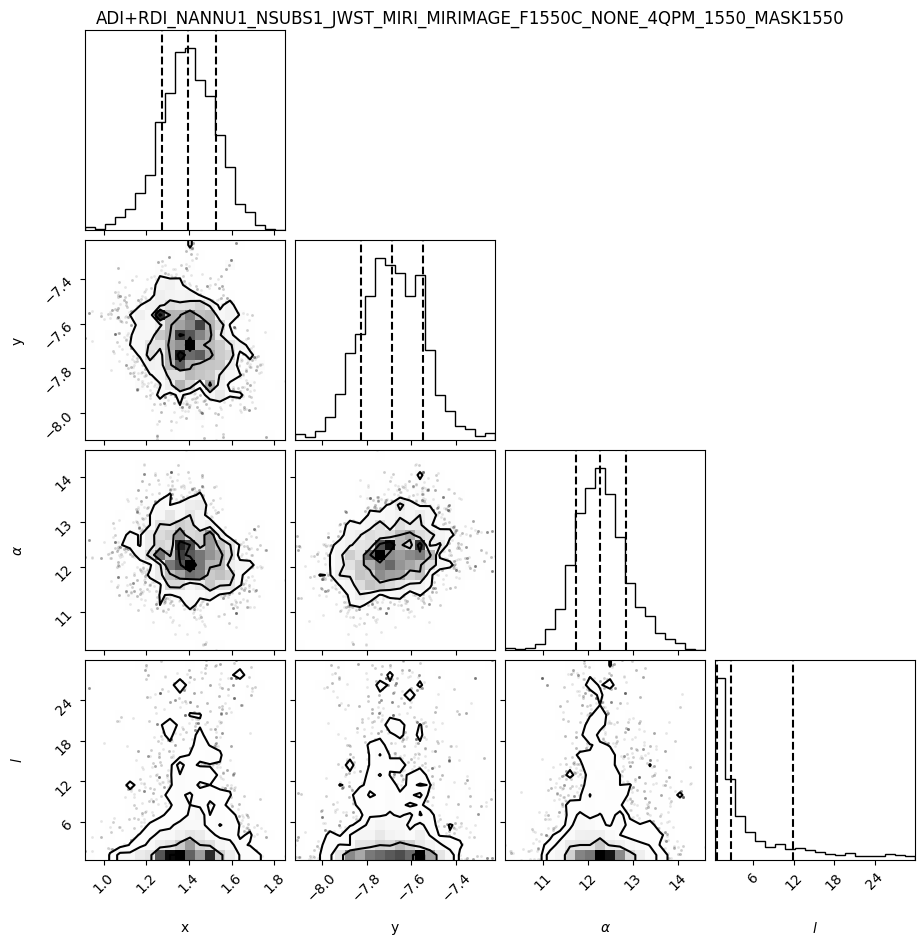

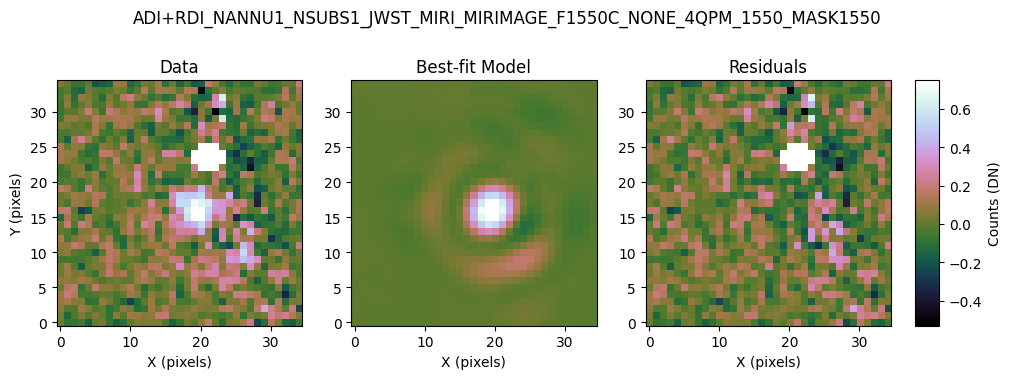

  0%|          | 0/1 [00:00<?, ?it/s]

Table saved to data_miri_hd65426/companions/KL50/C1/ADI+RDI_NANNU1_NSUBS1_JWST_MIRI_MIRIMAGE_F1550C_NONE_4QPM_1550_MASK1550-results_c1.ecsv
[spaceKLIP.psf:INFO] Generating on-axis and off-axis PSFs...
[spaceKLIP.psf:INFO]   Done.
Begin align and scale images for each wavelength
Align and scale finished
Starting KLIP for sector 1/1 with an area of 435899.96092129586 pix^2
Time spent on last sector: 0s
Time spent since beginning: 0s
First sector: Can't predict remaining time

Closing threadpool
Writing KLIPed Images to directory /System/Volumes/Data/user/kglidic/spaceKLIP/docs/source/tutorials/data_miri_hd65426/companions/KL50/C1/KLIP_FM
Running burn in
Burn in finished. Now sampling posterior
MCMC sampler has finished


[      root:WARNING] Too few points to create valid contours
[      root:WARNING] Too few points to create valid contours


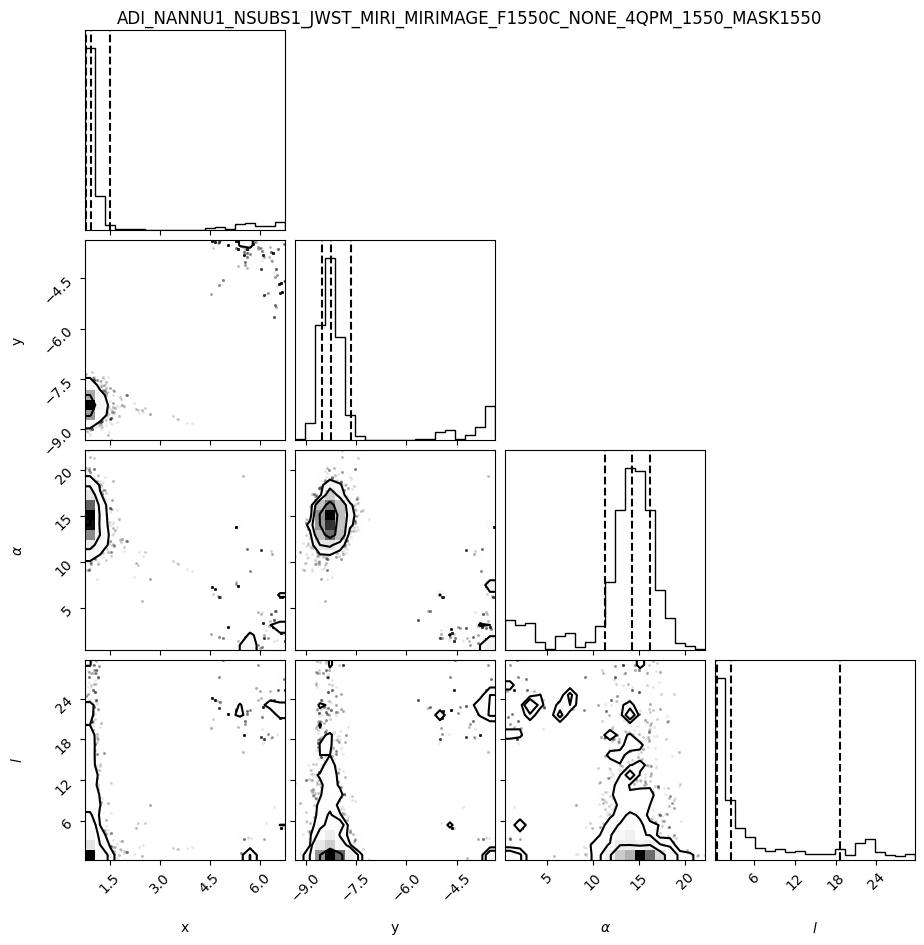

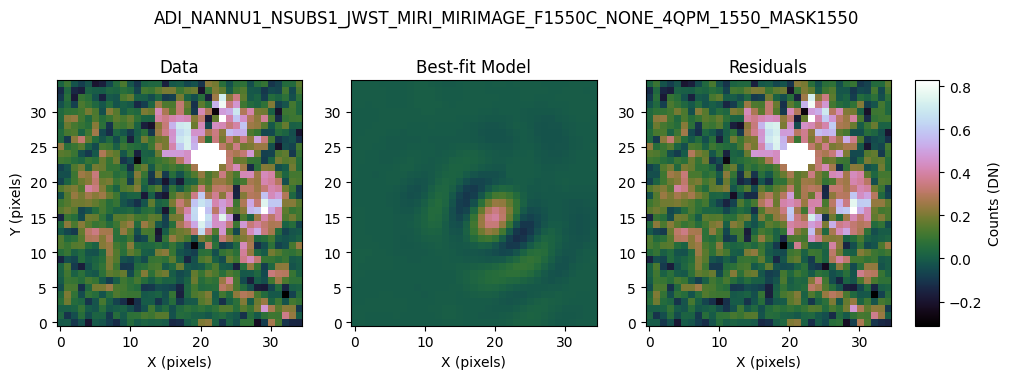

  0%|          | 0/1 [00:00<?, ?it/s]

Table saved to data_miri_hd65426/companions/KL50/C1/ADI_NANNU1_NSUBS1_JWST_MIRI_MIRIMAGE_F1550C_NONE_4QPM_1550_MASK1550-results_c1.ecsv
[spaceKLIP.psf:INFO] Generating on-axis and off-axis PSFs...
[spaceKLIP.psf:INFO]   Done.
Begin align and scale images for each wavelength
Align and scale finished
Starting KLIP for sector 1/1 with an area of 435899.96092129586 pix^2
Time spent on last sector: 0s
Time spent since beginning: 0s
First sector: Can't predict remaining time


/Users/kglidic/miniconda3/envs/sklip_n/lib/python3.11/site-packages/pyklip/fm.py:678: RuntimeWarning: invalid value encountered in divide
  perturb_mag = np.abs(quad_perturb/linear_perturb)
/Users/kglidic/miniconda3/envs/sklip_n/lib/python3.11/site-packages/pyklip/fm.py:678: RuntimeWarning: invalid value encountered in divide
  perturb_mag = np.abs(quad_perturb/linear_perturb)
/Users/kglidic/miniconda3/envs/sklip_n/lib/python3.11/site-packages/pyklip/fm.py:678: RuntimeWarning: invalid value encountered in divide
  perturb_mag = np.abs(quad_perturb/linear_perturb)
/Users/kglidic/miniconda3/envs/sklip_n/lib/python3.11/site-packages/pyklip/fm.py:678: RuntimeWarning: invalid value encountered in divide
  perturb_mag = np.abs(quad_perturb/linear_perturb)
/Users/kglidic/miniconda3/envs/sklip_n/lib/python3.11/site-packages/pyklip/fm.py:678: RuntimeWarning: invalid value encountered in divide
  perturb_mag = np.abs(quad_perturb/linear_perturb)
/Users/kglidic/miniconda3/envs/sklip_n/lib/python3


Closing threadpool
Writing KLIPed Images to directory /System/Volumes/Data/user/kglidic/spaceKLIP/docs/source/tutorials/data_miri_hd65426/companions/KL50/C1/KLIP_FM
Running burn in
Burn in finished. Now sampling posterior
MCMC sampler has finished


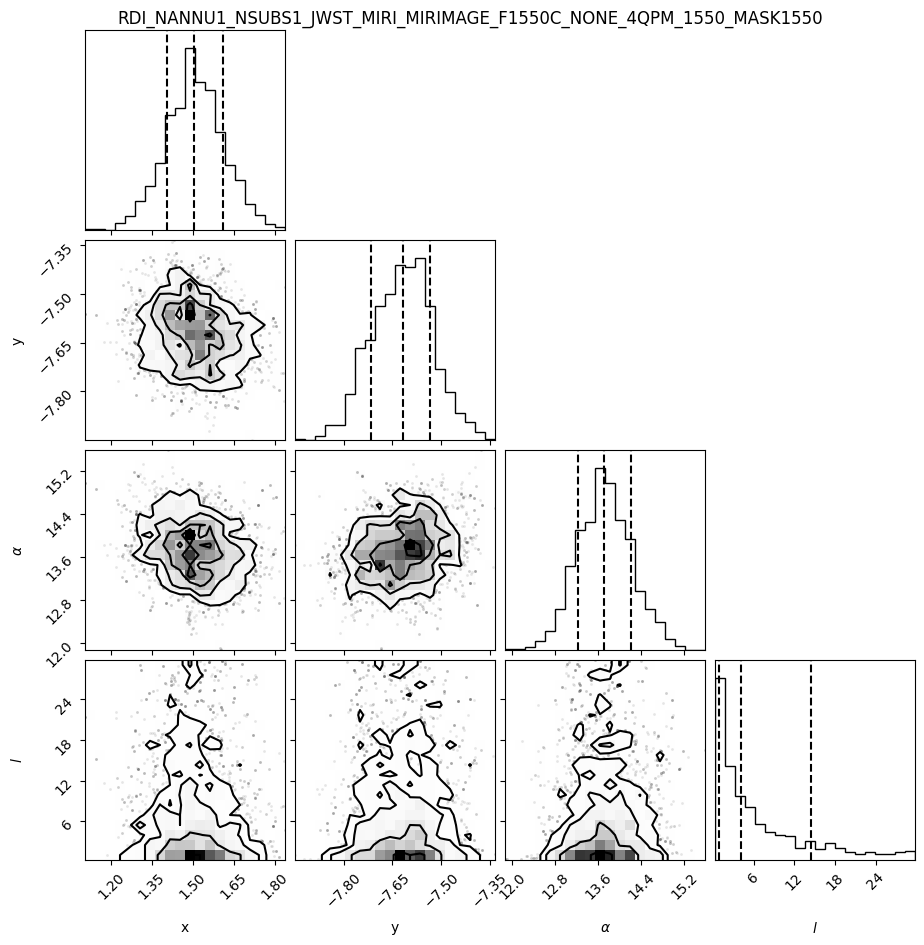

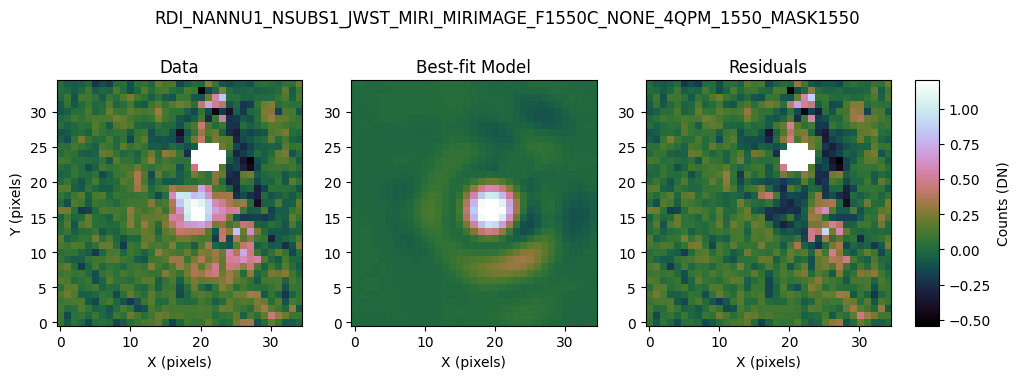

  0%|          | 0/1 [00:00<?, ?it/s]

Table saved to data_miri_hd65426/companions/KL50/C1/RDI_NANNU1_NSUBS1_JWST_MIRI_MIRIMAGE_F1550C_NONE_4QPM_1550_MASK1550-results_c1.ecsv


In [16]:
# Extract companions.
analysistools.extract_companions(
    companions=[[comp_dra, comp_ddec, 1e-4]],  # Delta RA, Dec, contrast.
    starfile=star_photometry_vot,  # Stellar photometry.
    mstar_err=0.0,  # Stellar photometry uncertainty.
    spectral_type=star_spectral_type,  # Spectral type.
    highpass=False,  # Apply high-pass filter?
    remove_background=False,  # Remove a constant background level?
    use_fm_psf=True,  # Use FM PSF generated with pyKLIP?
    fitmethod='mcmc',  # Sampling algorithm.
    fitkernel='diag',  # Covariance kernel for GP regression.
    # KL mode for companion extraction.
    # If 'max', then the maximum possible KL mode will be used.
    klmode='max',
    # Grab observation date from FITS header to query for the wavefront
    # measurement closest in time to the given date.
    date='auto',
    subtract=True,  # Subtract each extracted companion before next fit.
    # Instead of fitting for a companion at guessed location/contrast,
    # inject one into the data.
    inject=False,
    save_preklip=False,  # Save stage 2 files when injecting/killing a companion?
    overwrite=True,  # Compute new FM PSF and overwrite any existing one?
    subdir='companions'  # Output subdirectory.
)

The output plots provide a visual summary of the model fitting process and the derived companion parameters, offering insight into the quality of the fit and the confidence in the measurements.

1. **Corner Plot (MCMC Results)**: This plot shows the parameter space explored during MCMC fitting. It includes the posterior probability distributions for each parameter (diagonal panels) and the correlations between pairs of parameters (off-diagonal panels), helping assess uncertainties, confidence intervals, and correlations.

    * **x**: The fitted x-offset of the companion in pixels from the center.
    * **y**: The fitted y-offset of the companion in pixels from the center.
    * **α**: The flux scaling factor matching the FM to the observed data.
    * **l**: The "length scale" hyperparameter of the Gaussian process covariance function. It determines the smoothness of the noise model; a larger **l** suggests slower noise variation, while a smaller **l** indicates rapid changes.

2. **Best Fit Model**: These plots illustrate the model PSF fit to the data. The three panels show:

    * **Observed Data**: The first panel displays the KLIP-subtracted data.
    * **Best Fit Model**: The second panel shows the FM PSF of the companion, refined through an iterative fitting process to match the observed data best.
    * **Residuals**: The third panel shows the differences between the observed data and the best-fit model. A flat residual plot indicates a good fit.

Let's take a look at one of the best-fit result tables. 

In [17]:
# Optional: open the saved PDF files.
!open data_miri_hd65426/companions/KL50/C1/*pdf

In [18]:
# List the final result tables
!ls data_miri_hd65426/companions/KL50/C1/*ecsv

data_miri_hd65426/companions/KL50/C1/ADI+RDI_NANNU1_NSUBS1_JWST_MIRI_MIRIMAGE_F1550C_NONE_4QPM_1550_MASK1550-results_c1.ecsv
data_miri_hd65426/companions/KL50/C1/ADI_NANNU1_NSUBS1_JWST_MIRI_MIRIMAGE_F1550C_NONE_4QPM_1550_MASK1550-results_c1.ecsv
data_miri_hd65426/companions/KL50/C1/RDI_NANNU1_NSUBS1_JWST_MIRI_MIRIMAGE_F1550C_NONE_4QPM_1550_MASK1550-results_c1.ecsv


In [21]:
ecsv_tables = glob.glob('data_miri_hd65426/companions/KL50/C1/*ecsv')
ecsv_table = astropy.table.Table.read(ecsv_tables[0], format='ascii.ecsv')
ecsv_table

ID,RA,RA_ERR,DEC,DEC_ERR,FLUX_JY,FLUX_JY_ERR,FLUX_SI,FLUX_SI_ERR,FLUX_SI_ALT,FLUX_SI_ALT_ERR,CON,CON_ERR,DELMAG,DELMAG_ERR,APPMAG,APPMAG_ERR,MSTAR,MSTAR_ERR,SNR,LN(Z/Z0),TP_CORONMSK,TP_COMSUBST,FITSFILE
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object
1,0.10391796783650649,0.03982182815110453,-0.911536183278032,0.0478900962492812,4.836595711136334e-05,8.330798782949182e-06,nan,nan,6.023872635240269e-19,1.0375825025596385e-19,0.0014181376875493736,0.0002442672579452583,7.120704003206831,0.1870127336129527,13.794004911799593,0.1870127336129527,6.673300908592762,0.0,2.24882468540164,nan,0.6117333672584462,1.0,data_miri_hd65426/companions/KL50/C1/ADI_NANNU1_NSUBS1_JWST_MIRI_MIRIMAGE_F1550C_NONE_4QPM_1550_MASK1550-fitpsf_c1.fits


---
The results obtained here can be directly compared to the [JWST Early Release Science (ERS) coronagraphic observations of the super-Jupiter exoplanet HIP 65426b](https://iopscience.iop.org/article/10.3847/2041-8213/acd93e), published by Aarynn Carter et al. Specifically, we find in the tutorial an absolute magnitude (relative to Vega) of 13.794±0.1870, compared to the paper's report of 14.705±0.182. Differences can be due to various updates in the JWST pipeline (notably an update to MIRI flux calibration) and the spaceKLIP algorithm. Additionally, note that the ERS paper employs a different error analysis method. 

Congratulations on completing the analysis on HIP 65426 b with spaceKLIP!